# Tratamiento de datos de sensores

Cargamos librerías para análisis numérico, visualización y tests estadísticos.

In [1]:
import datetime
import functools
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp

from cubic.utils import SolarInfo  # Esta es para etiquetar eventos solares

Configuramos también parámetros de visualización y exportación

In [2]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["savefig.dpi"] = 200

Por último, definimos unas cuantas constantes que usaremos más adelante.

- `LAT` y `LON`: Geoposición de los sensores a monitorizar. La he cogido a ojo en Google Maps, pero lo mismo he fallado porque la he puesto en el centro mismo de la escuela. Si quisiésemos tener los sensores repartidos por localizaciones distantes, habría que asociar latitudes y longitudes con cada uno de ellos.
- `RAW_DATASET_PATH`: La ruta al fichero CSV con los datos de los sensores. Cuando consigsamos volcar los datos a un ftp, podremos cogerlos directamente de allí.

In [3]:
LAT, LON = 40.45, -3.73
RAW_DATASET_PATH = "../data/raw/etsiaab_temp_06_25.csv"

## Carga de datos

Cargamos el conjunto de datos con las temperaturas. Aprovechamos en la carga a especificar bien los tipos de datos porque me han asustado de que vienen muchos y no quiero que desborde la memoria.

In [4]:
df = pd.read_csv(
    RAW_DATASET_PATH,
    usecols=lambda x: x != "Line#",      # Esta columna no la queremos para nada
    index_col="Date",                    # Date será nuestro índice
    parse_dates=["Date"],                # Y como es fecha la tratamos como tal
    date_format="%d/%m/%y %H:%M:%S %z",  # Viene en este formato
    decimal=",",
).sort_index()

df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2025-06-27 00:00:00+02:00 to 2025-06-30 21:30:00+02:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2LR2    188 non-null    float64
 1   2TR2    188 non-null    float64
 2   2MR2    188 non-null    float64
 3   1LR2    188 non-null    float64
 4   1TR2    188 non-null    float64
 5   1MR2    188 non-null    float64
dtypes: float64(6)
memory usage: 10.3 KB


Veamos ahora las primeras filas tras la carga para ver la forma de los datos.

In [5]:
df.head(10)

,2LR2,2TR2,2MR2,1LR2,1TR2,1MR2
Date,,,,,,
2025-06-27 00:00:00+02:00,19.60,19.67,19.77,19.35,20.18,19.92
2025-06-27 00:30:00+02:00,19.17,19.37,19.28,19.09,19.62,19.30
2025-06-27 01:00:00+02:00,18.25,18.23,18.25,18.14,18.62,18.36
2025-06-27 01:30:00+02:00,17.09,16.94,16.71,16.66,17.20,16.92
2025-06-27 02:00:00+02:00,16.54,16.17,16.11,16.26,16.49,16.11
2025-06-27 02:30:00+02:00,16.15,16.00,15.70,16.08,16.30,15.93
2025-06-27 03:00:00+02:00,15.53,15.27,15.14,15.42,15.68,15.27
2025-06-27 03:30:00+02:00,15.06,14.86,14.91,14.86,15.18,15.10
2025-06-27 04:00:00+02:00,14.82,14.65,14.52,14.48,14.97,14.63


A primera vista parece que los valores son coherentes y que el índice está ordenado temporalmente.

## Ingeniería de características

Vamos a crear nuevas características que nos pueden ayudar a encontrar información relevante.

### 1. Información del momento del día

Añadiremos información de en qué momento del día estamos (`"dawn"`, `"sunrise"`, `"noon"`, `"sunset"` o `"dusk"`) a cada registro.

In [6]:
etsiaab_solar_info = SolarInfo(LAT, LON)
df["Solar event"] = df.index.map(etsiaab_solar_info.closest_event)
df

,2LR2,2TR2,2MR2,1LR2,1TR2,1MR2,Solar event
Date,,,,,,,
2025-06-27 00:00:00+02:00,19.60,19.67,19.77,19.35,20.18,19.92,dawn
2025-06-27 00:30:00+02:00,19.17,19.37,19.28,19.09,19.62,19.30,dawn
2025-06-27 01:00:00+02:00,18.25,18.23,18.25,18.14,18.62,18.36,dawn
2025-06-27 01:30:00+02:00,17.09,16.94,16.71,16.66,17.20,16.92,dawn
2025-06-27 02:00:00+02:00,16.54,16.17,16.11,16.26,16.49,16.11,dawn
...,...,...,...,...,...,...,...
2025-06-30 19:30:00+02:00,25.91,26.21,26.34,26.04,26.32,26.34,sunset
2025-06-30 20:00:00+02:00,26.53,26.66,26.87,26.62,26.94,27.02,sunset
2025-06-30 20:30:00+02:00,28.08,27.95,28.14,27.84,27.99,28.20,sunset


### Partes de las fechas

Ya que es altamente probable que los datos estén influidos por eventos periódicos (estaciones), vamos a extraer columnas de la fecha.

In [7]:
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.date
df["hour"] = df.index.hour + df.index.minute / 60
df[["year", "month", "day", "hour"]]

,year,month,day,hour
Date,,,,
2025-06-27 00:00:00+02:00,2025,6,2025-06-27,0.0
2025-06-27 00:30:00+02:00,2025,6,2025-06-27,0.5
2025-06-27 01:00:00+02:00,2025,6,2025-06-27,1.0
2025-06-27 01:30:00+02:00,2025,6,2025-06-27,1.5
2025-06-27 02:00:00+02:00,2025,6,2025-06-27,2.0
...,...,...,...,...
2025-06-30 19:30:00+02:00,2025,6,2025-06-30,19.5
2025-06-30 20:00:00+02:00,2025,6,2025-06-30,20.0
2025-06-30 20:30:00+02:00,2025,6,2025-06-30,20.5


### Medias de OTC y no OTC

Calculamos la media global de todos los sensores dentro y fuera de OTC por _timestamp_ y su diferencia.

In [8]:
df["OTC_mean"] = df[["2LR2", "2TR2", "2MR2"]].mean(axis=1)
df["noOTC_mean"] = df[["1LR2", "1TR2", "1MR2"]].mean(axis=1)
df["diff_OTC_noOTC"] = df["OTC_mean"] - df["noOTC_mean"]
df[["OTC_mean", "noOTC_mean", "diff_OTC_noOTC"]]

,OTC_mean,noOTC_mean,diff_OTC_noOTC
Date,,,
2025-06-27 00:00:00+02:00,19.680000,19.816667,-0.136667
2025-06-27 00:30:00+02:00,19.273333,19.336667,-0.063333
2025-06-27 01:00:00+02:00,18.243333,18.373333,-0.130000
2025-06-27 01:30:00+02:00,16.913333,16.926667,-0.013333
2025-06-27 02:00:00+02:00,16.273333,16.286667,-0.013333
...,...,...,...
2025-06-30 19:30:00+02:00,26.153333,26.233333,-0.080000
2025-06-30 20:00:00+02:00,26.686667,26.860000,-0.173333
2025-06-30 20:30:00+02:00,28.056667,28.010000,0.046667


Por supuesto estamos asumiento que los rangos de valores son los mismos en todos los sensores. Si no habría que normalizar antes de realizar estos cálculos.

## EDA

Veamos un resumen estadístico rápido con todas las nuevas columnas calculadas.

In [9]:
desc = df.describe()
desc.T

,count,mean,std,min,25%,50%,75%,max
2LR2,188.0,29.541809,8.810158,13.830000,20.972500,29.780000,37.487500,42.980000
2TR2,188.0,29.663298,9.020332,13.750000,21.165000,29.630000,38.357500,43.160000
2MR2,188.0,29.753617,8.982760,13.510000,21.090000,30.070000,38.455000,43.180000
1LR2,188.0,29.431649,8.849801,13.580000,20.905000,30.005000,37.700000,42.340000
1TR2,188.0,29.413138,8.734557,13.920000,21.302500,29.150000,37.945000,42.700000
1MR2,188.0,29.347606,8.716130,13.620000,21.197500,29.675000,37.540000,42.700000
year,188.0,2025.000000,0.000000,2025.000000,2025.000000,2025.000000,2025.000000,2025.000000
month,188.0,6.000000,0.000000,6.000000,6.000000,6.000000,6.000000,6.000000
hour,188.0,11.515957,6.827301,0.000000,5.500000,11.500000,17.500000,23.500000
OTC_mean,188.0,29.652908,8.922031,13.696667,21.149167,29.873333,37.780833,42.806667


A ojo no me parece que haya ninguna discrepancia en los valores.

### Estadísticos por sensor

Vamos a centrarnos en la estadística descriptiva de los sensores, básicamente el rango, medias y dispersión por columna.

In [10]:
df[["2LR2", "2TR2", "2MR2", "1LR2", "1TR2", "1MR2"]].describe().T

,count,mean,std,min,25%,50%,75%,max
2LR2,188.0,29.541809,8.810158,13.83,20.9725,29.780,37.4875,42.98
2TR2,188.0,29.663298,9.020332,13.75,21.1650,29.630,38.3575,43.16
2MR2,188.0,29.753617,8.982760,13.51,21.0900,30.070,38.4550,43.18
1LR2,188.0,29.431649,8.849801,13.58,20.9050,30.005,37.7000,42.34
1TR2,188.0,29.413138,8.734557,13.92,21.3025,29.150,37.9450,42.70
1MR2,188.0,29.347606,8.716130,13.62,21.1975,29.675,37.5400,42.70


A simple vista parecen valores que tienen sentido, no sé hasta qué punto hay algún rango sospechoso por sensor. Saquemos una correlación entre los mismos para asegurarnos de que no hay nada que discrepe demasiado.

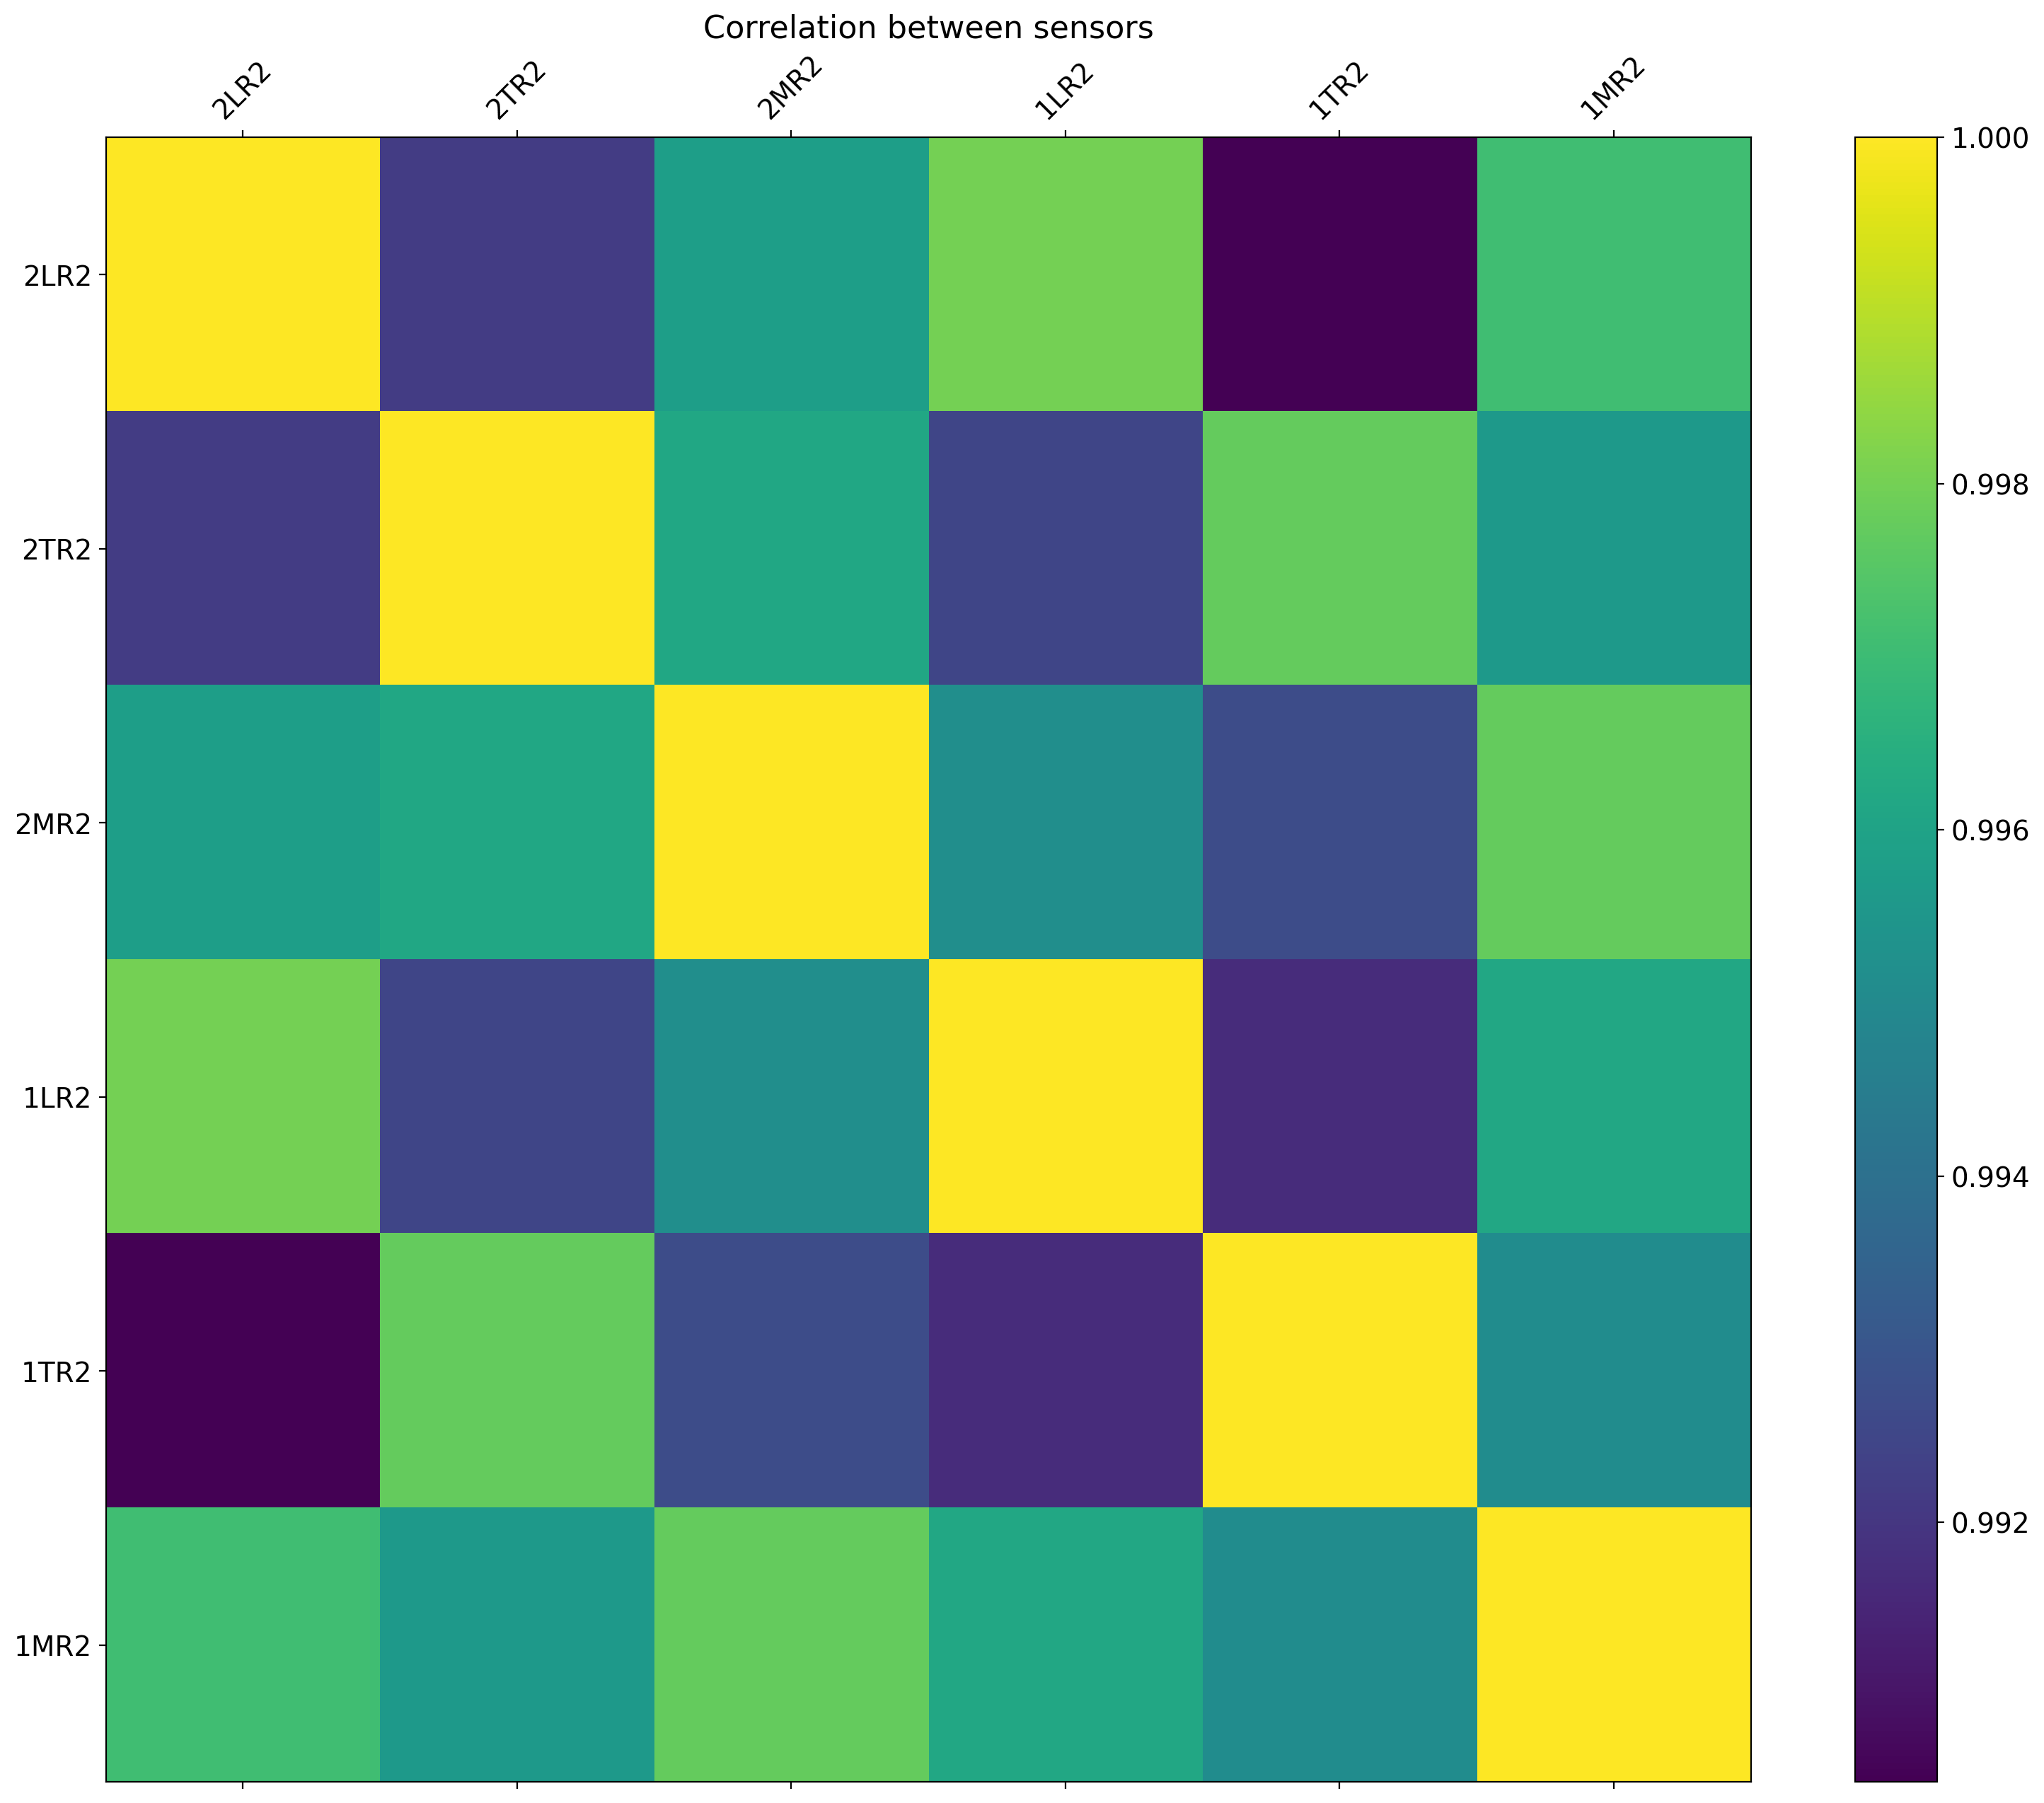

In [11]:
sensors_df = df[["2LR2", "2TR2", "2MR2", "1LR2", "1TR2", "1MR2"]]

f = plt.figure(figsize=(19, 15))
plt.matshow(sensors_df.corr(), fignum=f.number)
plt.xticks(range(sensors_df.select_dtypes(["number"]).shape[1]), sensors_df.select_dtypes(["number"]).columns, fontsize=14, rotation=45)
plt.yticks(range(sensors_df.select_dtypes(["number"]).shape[1]), sensors_df.select_dtypes(["number"]).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.savefig("correlación-entre-sensores.svg", bbox_inches="tight")
plt.title("Correlation between sensors", fontsize=16)
plt.show();

Mucha correlación y simetría, así que tranquilidad. Si no hubiese correlación es cuando nos tendríamos que haber preocupado.

## Serie temporal de todas las temperaturas

Veamos ahora una serie comparativa de sensores con y sin OTC.

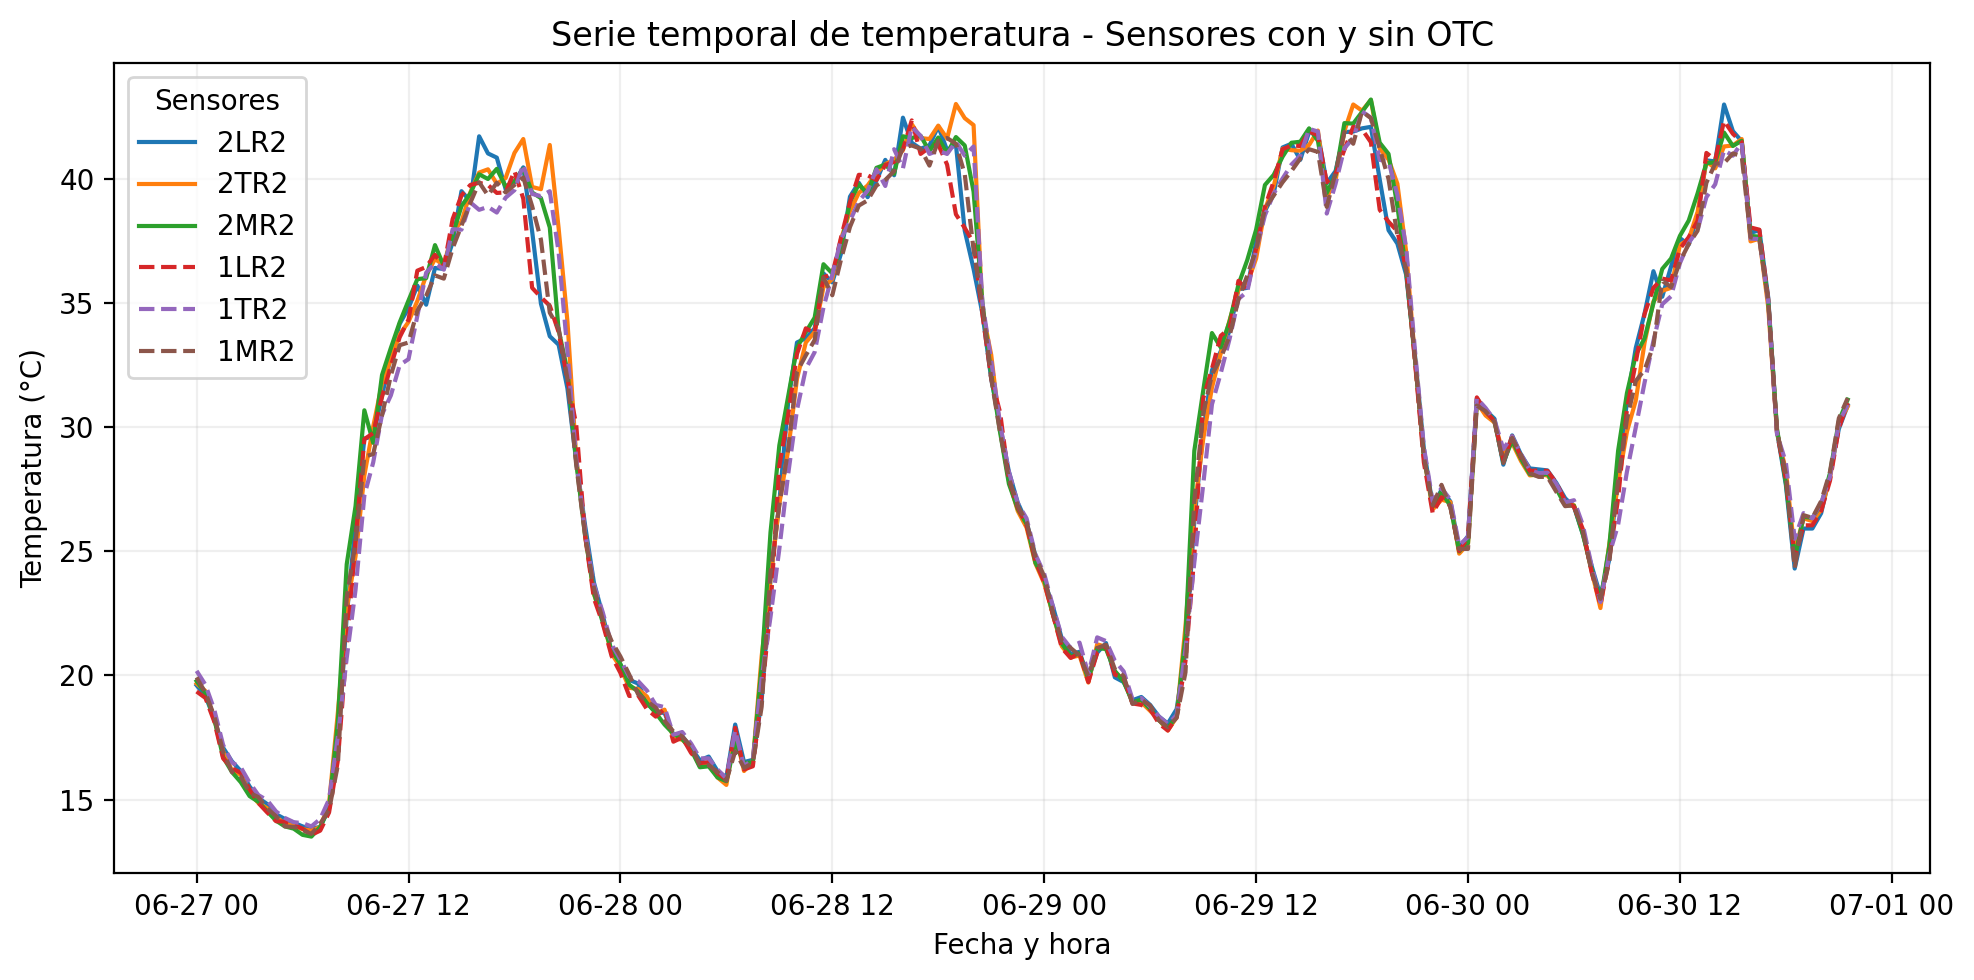

In [12]:
for col in ["2LR2", "2TR2", "2MR2"]:
    plt.plot(df.index, df[col], label=col, linewidth=1.5)
for col in ["1LR2", "1TR2", "1MR2"]:
    plt.plot(df.index, df[col], label=col, linestyle="--", linewidth=1.5)
plt.legend(title="Sensores")
plt.title("Serie temporal de temperatura - Sensores con y sin OTC")
plt.ylabel("Temperatura (°C)")
plt.xlabel("Fecha y hora")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig("serie-temporal-de-todas-las-temperaturas.svg", bbox_inches="tight")
plt.show();

Se observa que:

1. La evolución diaria, esto es, máximos durante el día, mínimos durante la noche.
2. En la mayoría de los picos, las OTC van por encima.

### _Boxplots_ por sensor y condición

Ahora comparamos medianas y colas por sensor.

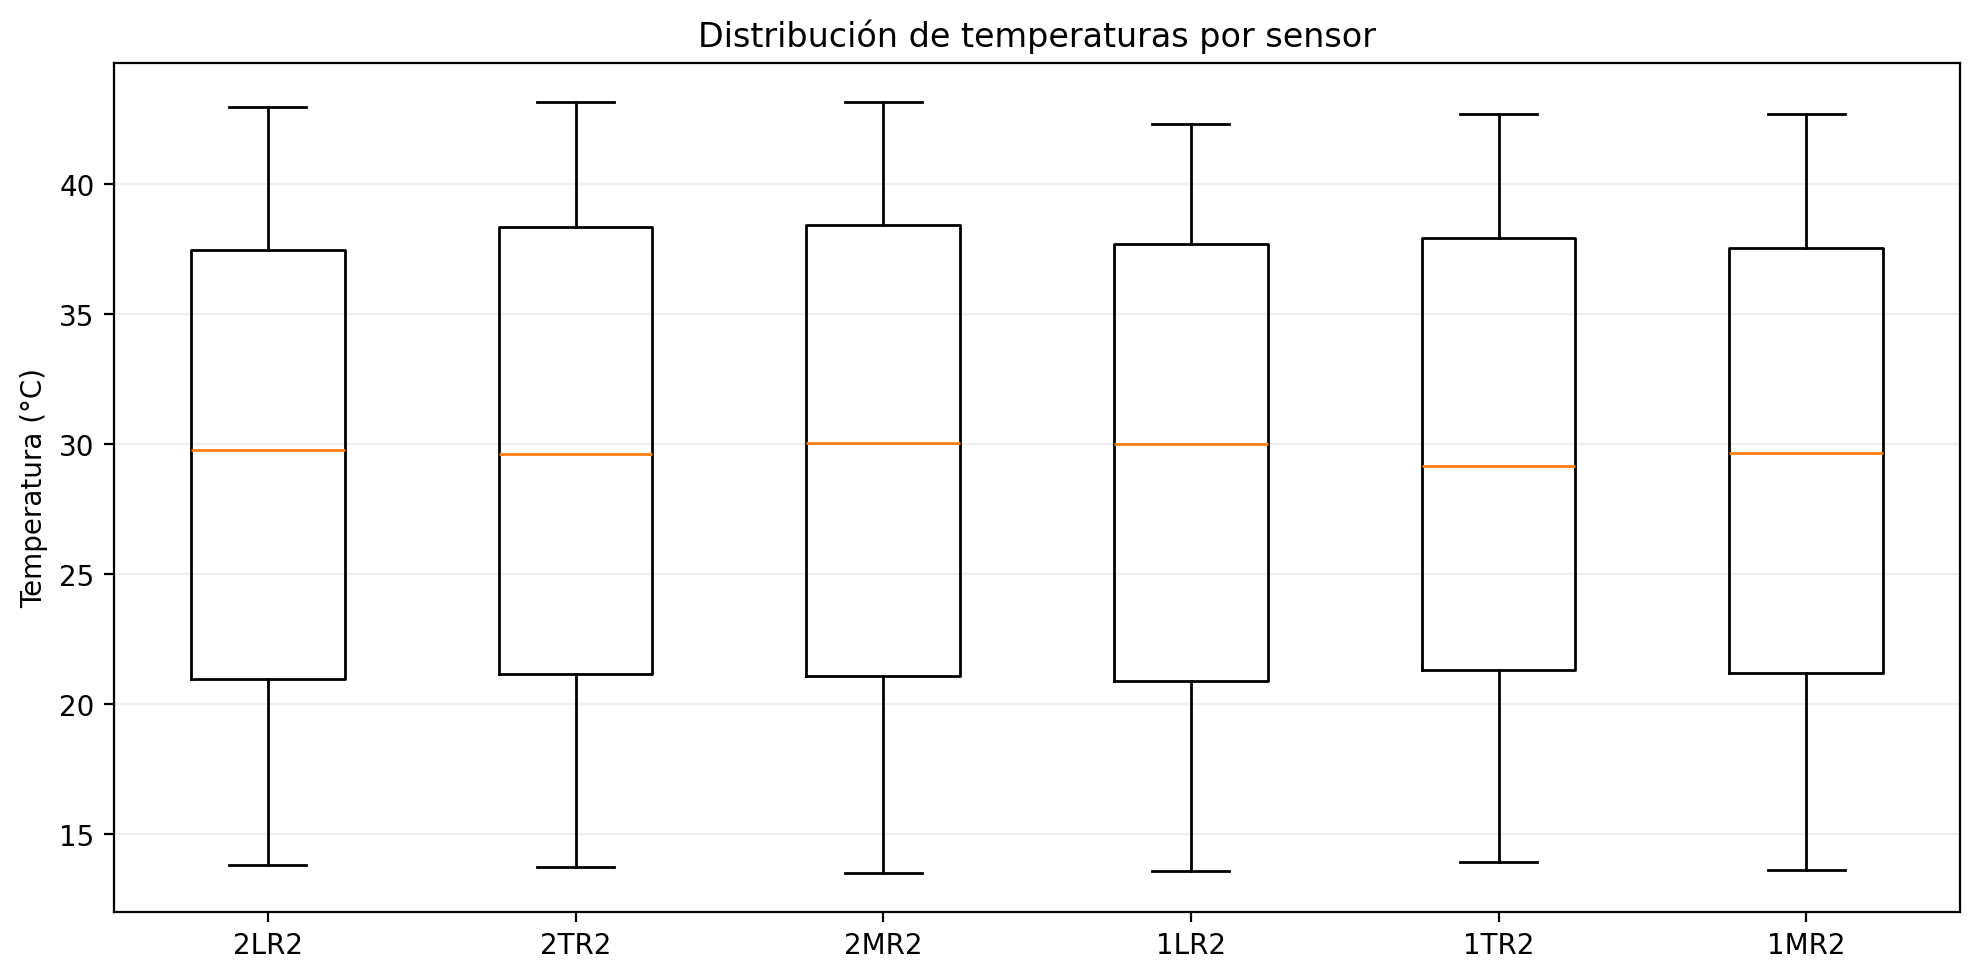

In [13]:
data = [df[col] for col in ["2LR2", "2TR2", "2MR2", "1LR2", "1TR2", "1MR2"]]
plt.boxplot(data, tick_labels=["2LR2","2TR2","2MR2","1LR2","1TR2","1MR2"])
plt.title("Distribución de temperaturas por sensor")
plt.ylabel("Temperatura (°C)")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.savefig("boxplots-por-sensor-y-condición.svg", bbox_inches="tight")
plt.show();

A lo mejor un lince de la estadística puede observar algo, pero a mí a ojo no me parece observar ninguna diferencia relevante. Si nos ponemos tiquismiquis podemos decir que las temperaturas con OTC son ligeramente superiores.

### Diferencia media entre OTC y sin OTC a lo largo del día

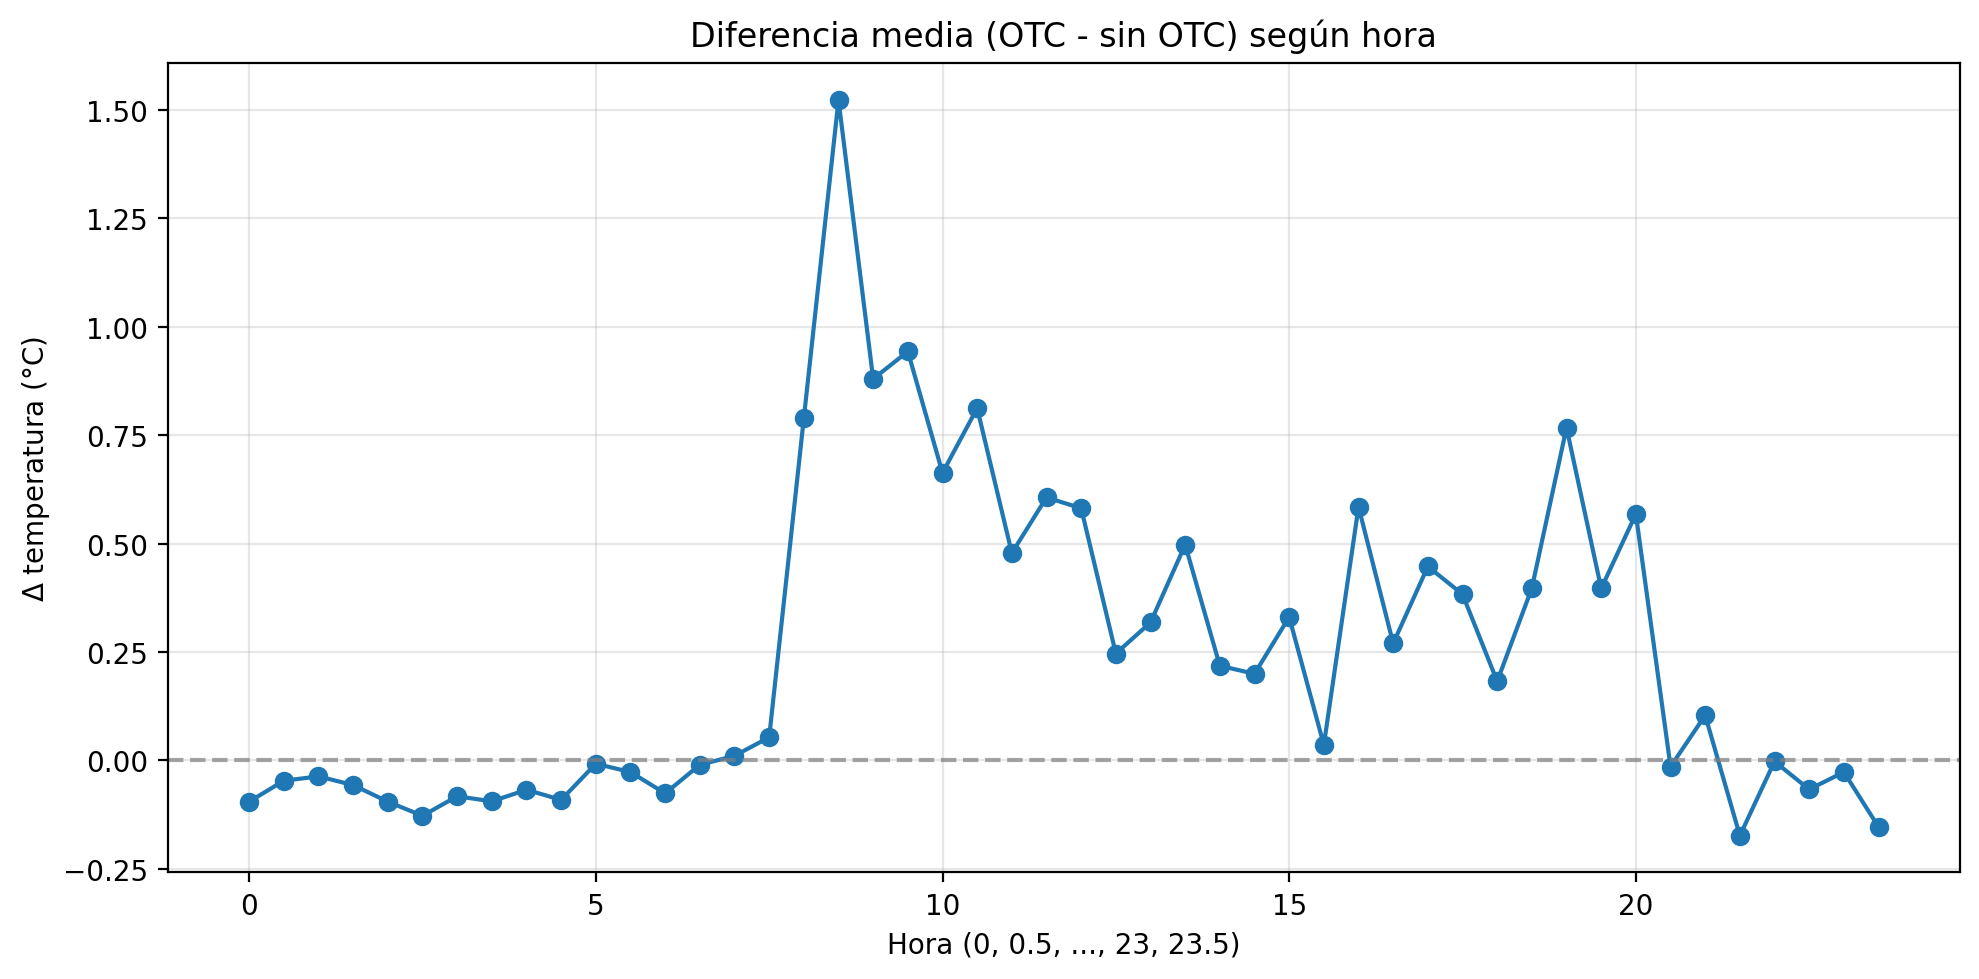

In [14]:
mean_diff_by_hour = df.groupby('hour', sort=True)['diff_OTC_noOTC'].mean()

plt.plot(mean_diff_by_hour.index, mean_diff_by_hour.values, marker="o")
plt.axhline(0, color="grey", linestyle="--", alpha=0.7)
plt.title("Diferencia media (OTC - sin OTC) según hora")
plt.xlabel("Hora (0, 0.5, ..., 23, 23.5)")
plt.ylabel("$\Delta$ temperatura (°C)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("diferencia-media-otc-y-no-otc-por-hora.svg", bbox_inches="tight")
plt.show();

Se observa que:

1. Las OTC calientan principalmente durante las horas centrales del día.
2. Por la noche y durante las primeras horas, el efecto de las OTC es incluso negativo.

### Boxplot diferencia OTC y sin OTC por evento solar

Comparamos diferencias por `dawn`, `sunrise`, `noon`, `sunset`, `dusk`.

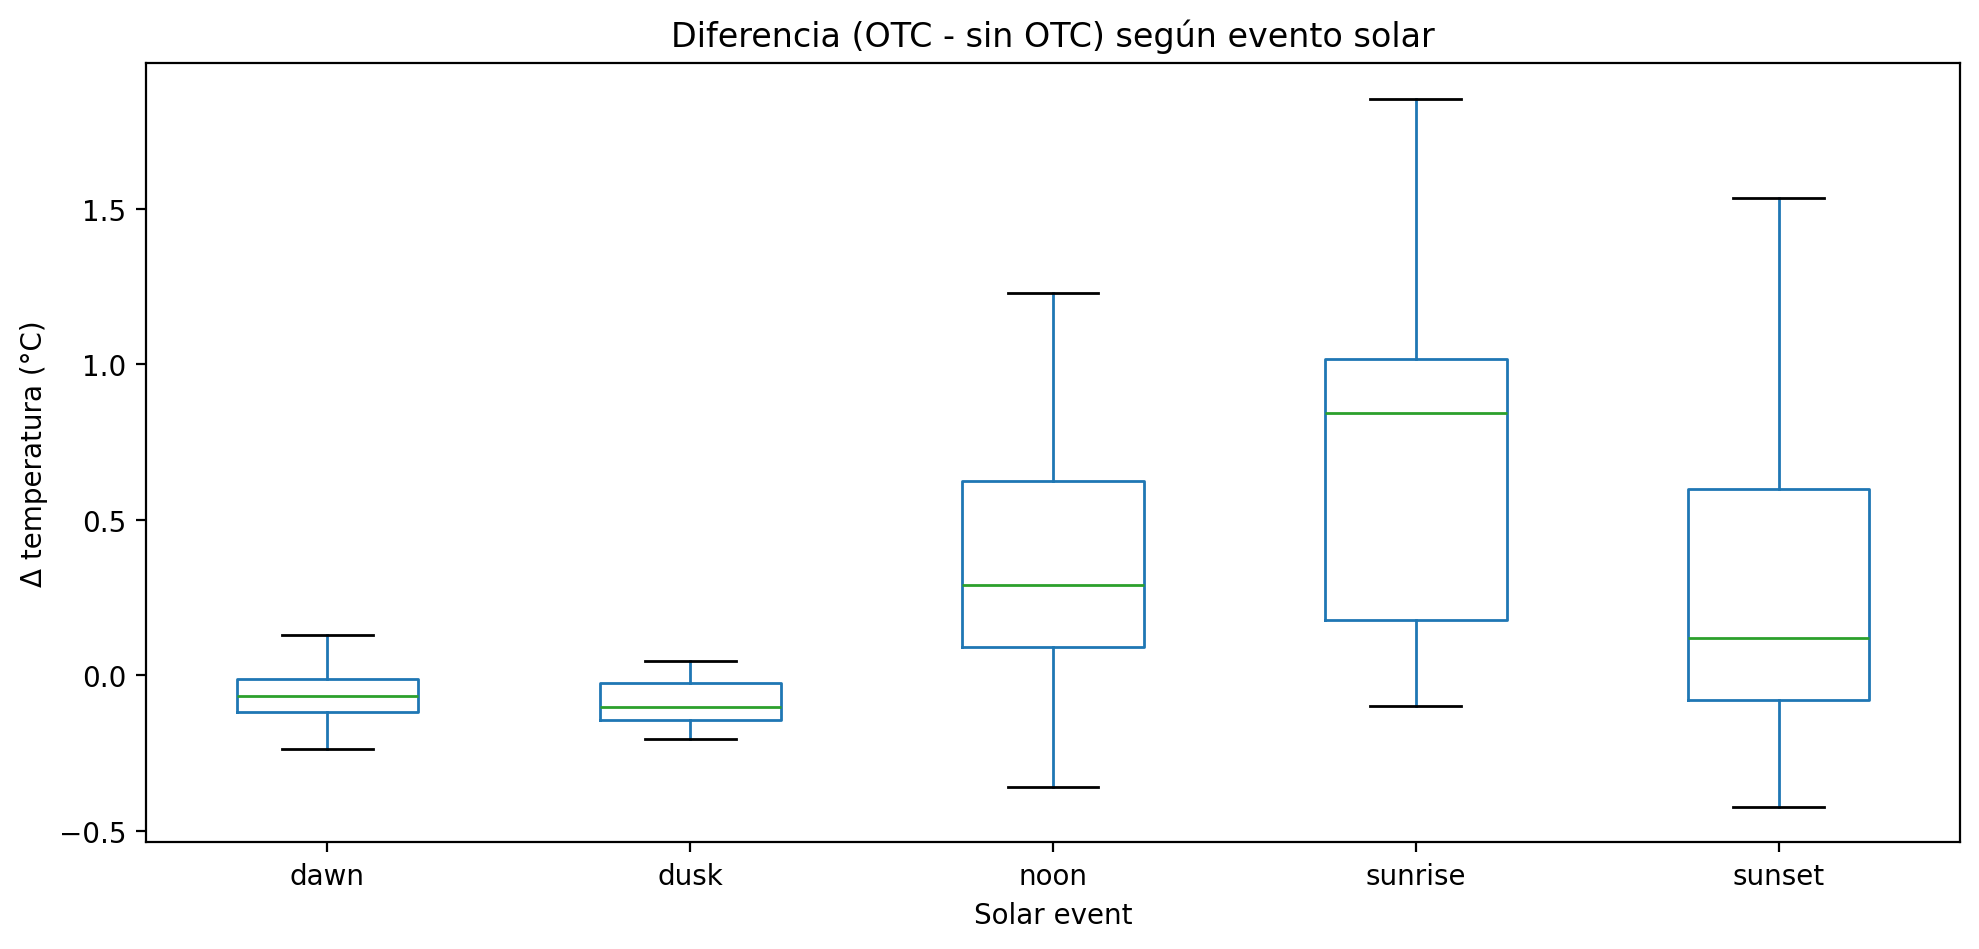

In [15]:
df.boxplot(column="diff_OTC_noOTC", by="Solar event", grid=False)
plt.title("Diferencia (OTC - sin OTC) según evento solar")
plt.suptitle("")
plt.ylabel('Δ temperatura (°C)')
plt.tight_layout()
plt.savefig("diferencia-por-evento-solar.svg", bbox_inches="tight")
plt.show();

Se observa que:

1. Día: la diferencia es claramente positiva, la OTC calienta más de media.
2. Noche: la diferencia está más cerca de cero o es incluso negativa en algunos momentos (puede enfriar levemente).
3. Dawn/dusk (crepúsculo): valores intermedios, cercanos a cero.

### Histograma de diferencias

Veamos la distribución de frecuencias de las diferencias de temperaturas existentes.

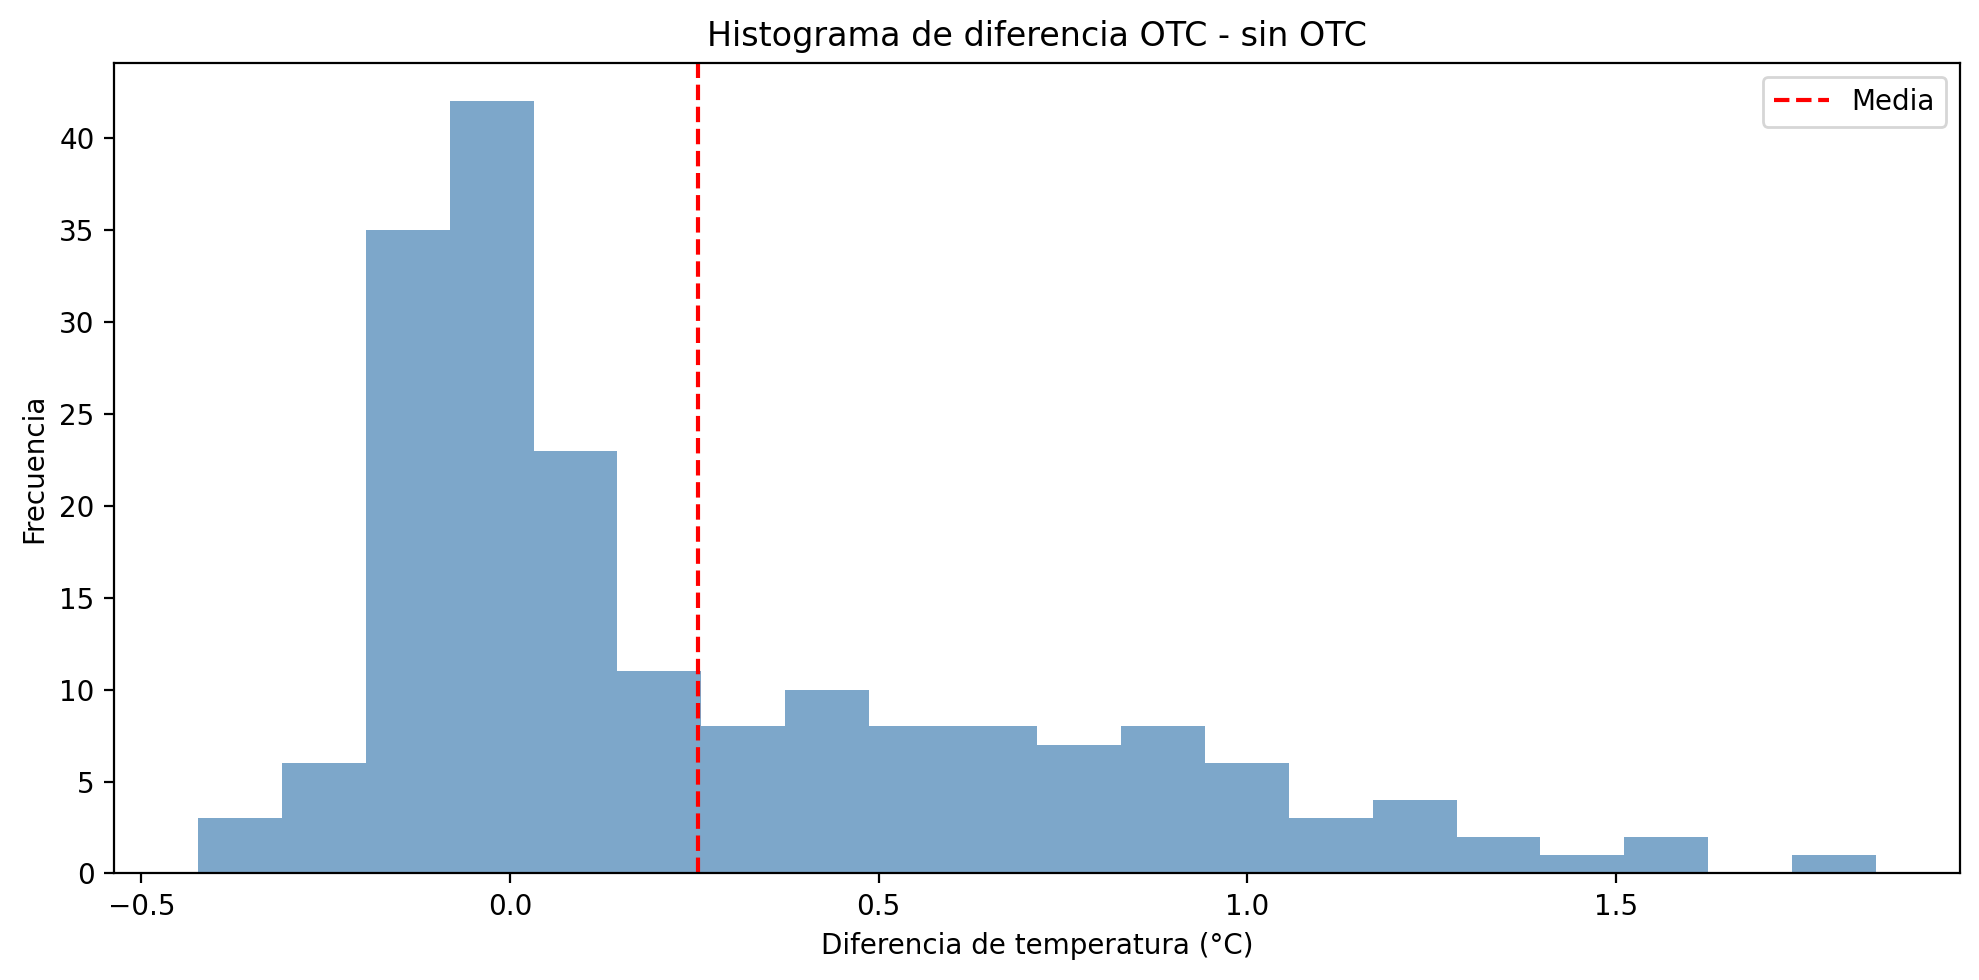

In [16]:
plt.hist(df["diff_OTC_noOTC"], bins=20, color="steelblue", alpha=0.7)
plt.axvline(df["diff_OTC_noOTC"].mean(), color="red", linestyle="--", label="Media")
plt.title("Histograma de diferencia OTC - sin OTC")
plt.xlabel("Diferencia de temperatura (°C)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.savefig("histograma-diferencia-otc-nootc.svg", bbox_inches="tight")
plt.show();

Se observa que:

1. Es mucho más claro que la mayoría de las diferencias están entre 0 y 0,5 grados.
2. Hay algunos valores negativos, pero está por encima de cero.

### Heatmap horario de diferencia OTC vs. sin OTC

Vamos a sacar un mapa de calor para poder ver la diferencia OTC - sin OTC por hora cada diferente día. Las zonas más oscuras serán las horas y los días donde la OTC enfría, mientras que las zonas más amarillas y blancas serán las horas/días donde la OTC calienta.

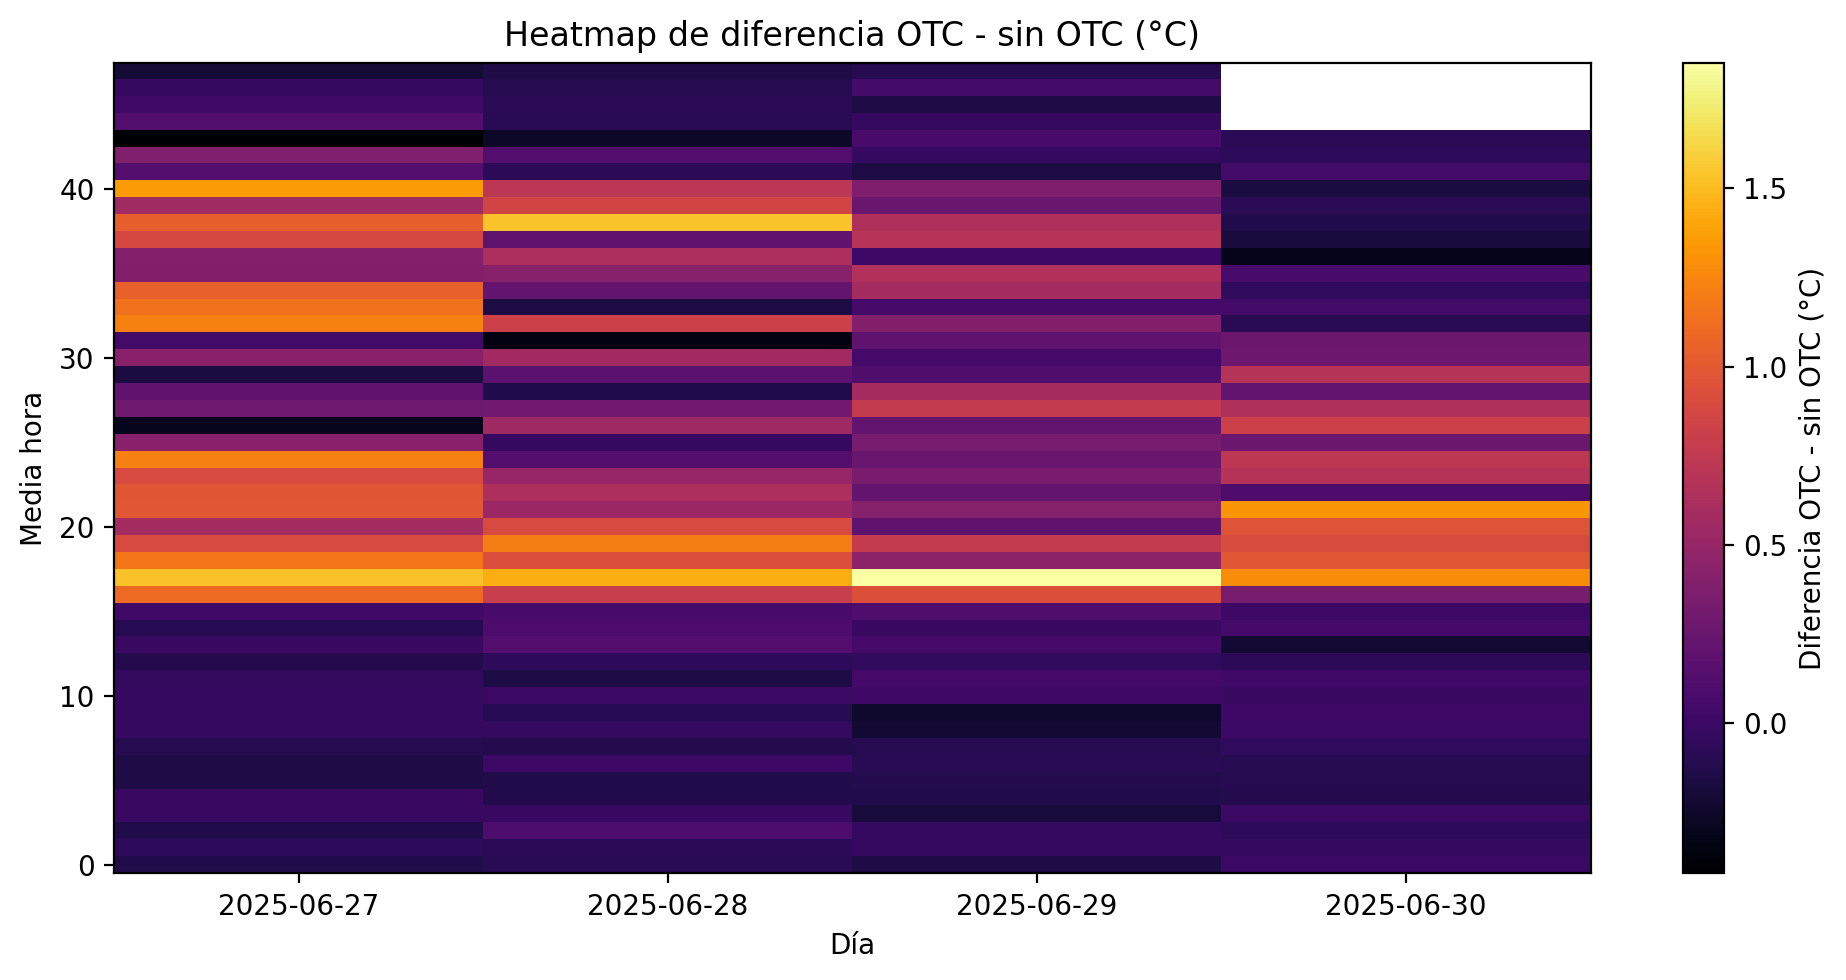

In [17]:
pivot = df.pivot_table(index="hour", columns="day", values="diff_OTC_noOTC")

plt.title("Heatmap de diferencia OTC - sin OTC (°C)")
plt.xlabel("Día")
plt.ylabel("Media hora")
plt.imshow(pivot, aspect="auto", cmap="inferno", origin="lower")
plt.colorbar(label="Diferencia OTC - sin OTC (°C)")
plt.xticks(ticks=range(len(pivot.columns)), labels=pivot.columns)
plt.tight_layout()
plt.savefig("heatmap-horario-de-diferencia-otc-vs-sin-otc.svg", bbox_inches="tight")
plt.show();

Vemos que durante el mediodía y primeras horas de la tarde los colores tienden a ser más cálidos y de madrugada más fríos. Si algún día es atípico (p.ej. un día nublado), se podrían ver patrones diferentes.

### Boxplot de diferencias por hora

Sacamos este boxplot para ver cada media hora dónde están la mediana y el grueso de los datos. Es de esperar que las horas centrales del día tengan la mediana muy por encima de 0 (OTC calienta), y la noche alrededor de cero o negativo (OTC enfría).

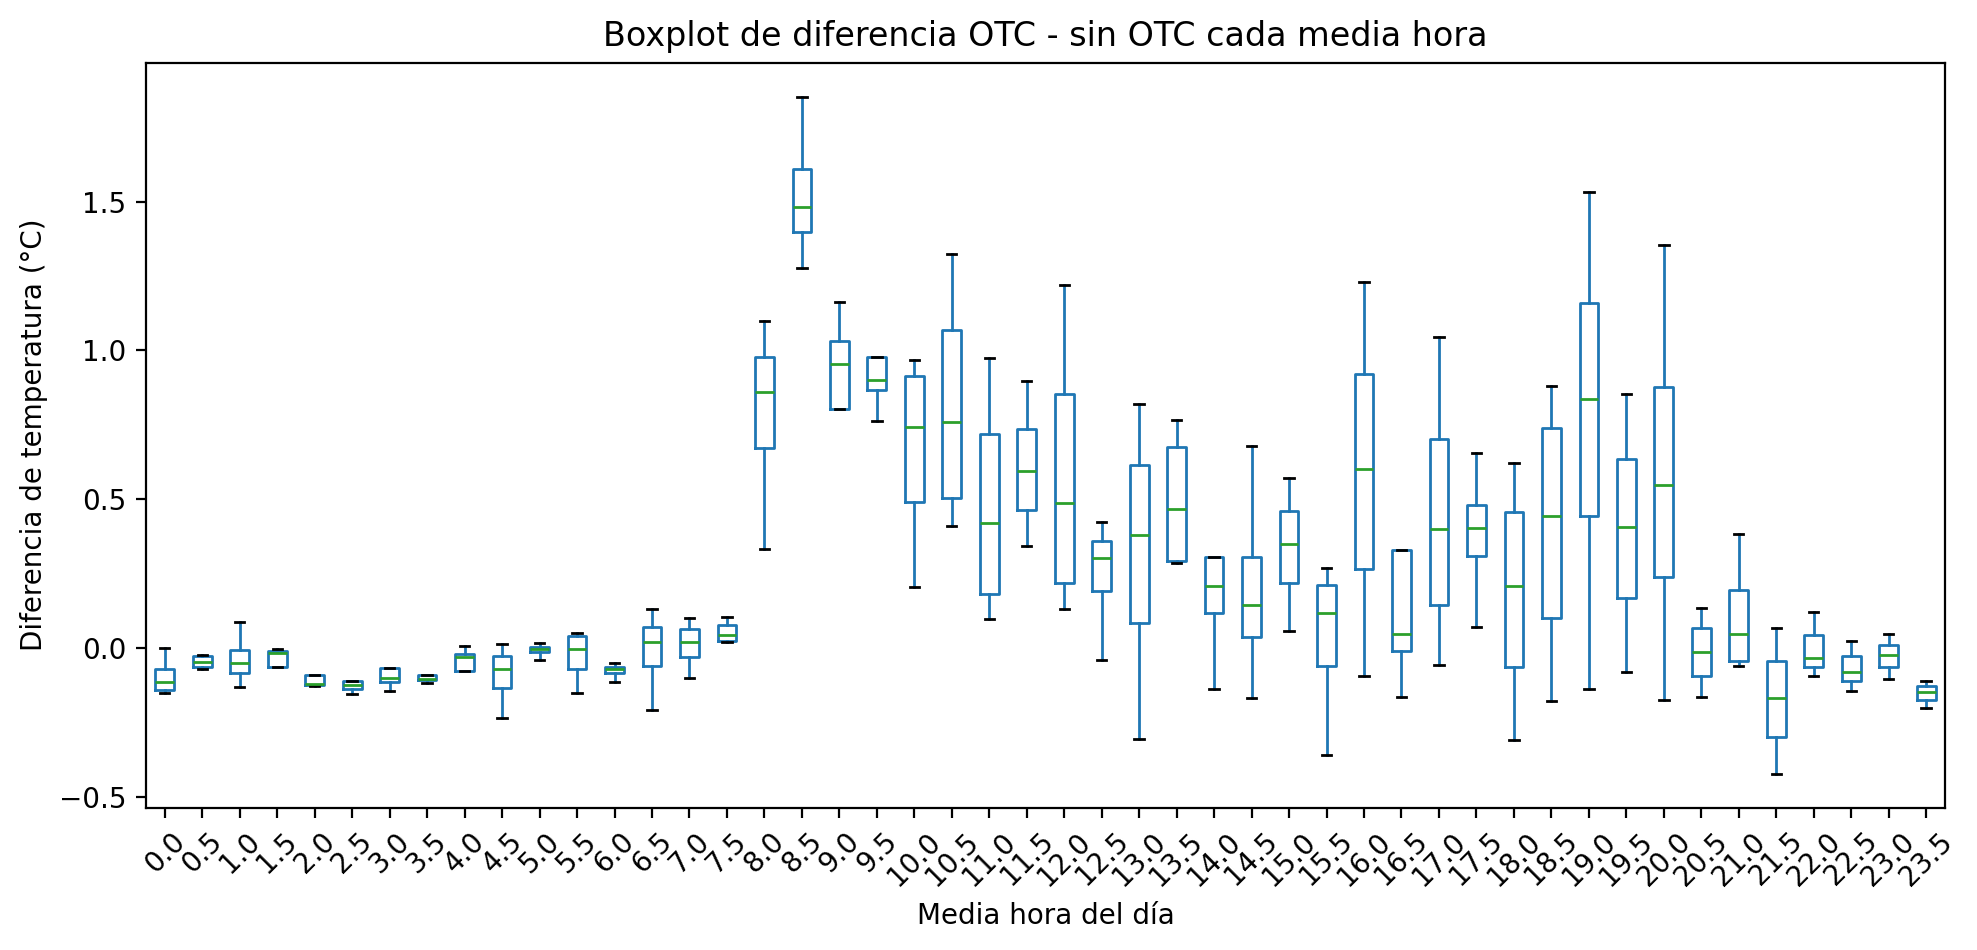

In [18]:
df.boxplot(column="diff_OTC_noOTC", by="hour", grid=False, showfliers=False)
plt.title("Boxplot de diferencia OTC - sin OTC cada media hora")
plt.suptitle("")
plt.xlabel("Media hora del día")
plt.ylabel("Diferencia de temperatura (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("boxplot-de-diferencias-por-hora.svg", bbox_inches="tight")
plt.show();

Nos viene bien para identificar horas donde la diferencia varía mucho o para ver las horas de transición (la diferencia entre las 07:30 y las 8:00 de la mañana es brutal).

### Histograma de todas las temperaturas

Superponemos los histogramas de OTC y no-OTC para ver la dispersión total y los posibles _outliers_.

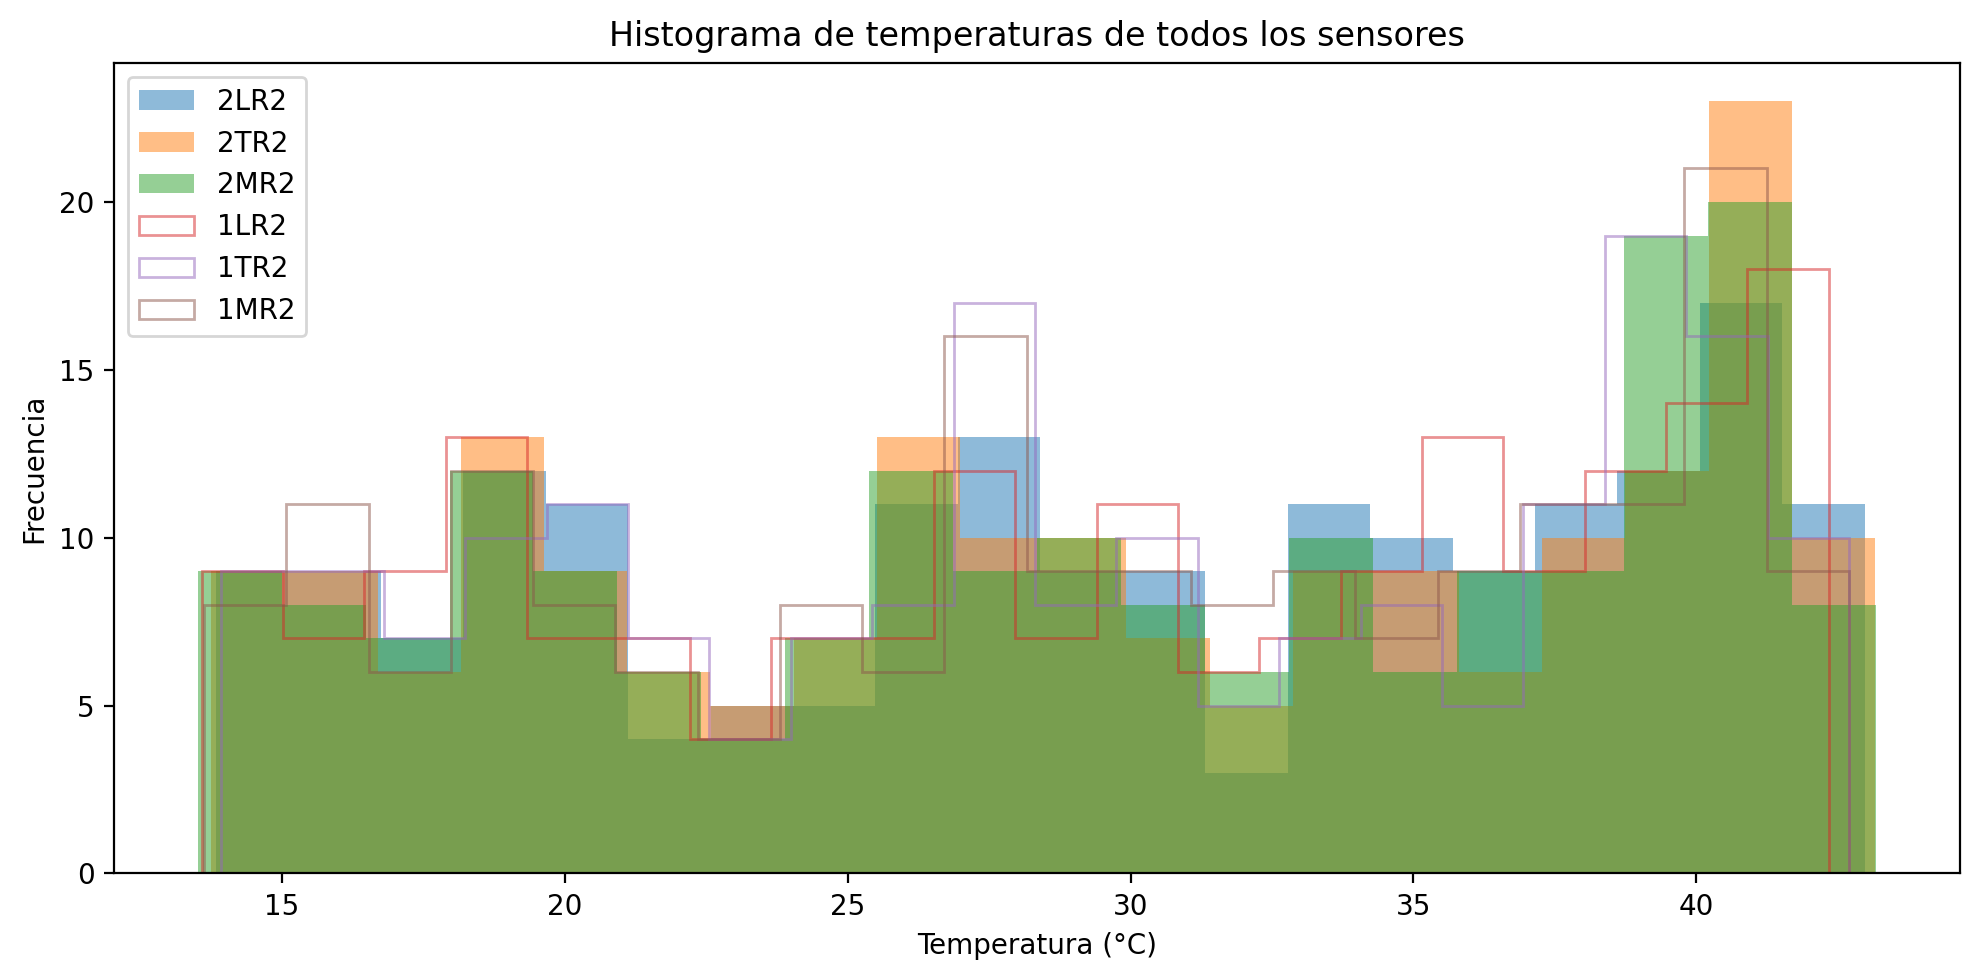

In [19]:
for col in ["2LR2", "2TR2", "2MR2"]:
    plt.hist(df[col], bins=20, alpha=0.5, label=col)
for col in ["1LR2", "1TR2", "1MR2"]:
    plt.hist(df[col], bins=20, alpha=0.5, label=col, histtype="step")
plt.title("Histograma de temperaturas de todos los sensores")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.savefig("histograma-de-todas-las-temperaturas.svg", bbox_inches="tight")
plt.show();

Parecía buena idea, pero la verdad es que no veo mucho aquí. A lo mejor saber que ciertos sensores ven con menos frecuencia algo que otros ven con más frecuencia nos puede dar una idea de algún error, pero no, no veo nada de nada.

### Correlación de sensores

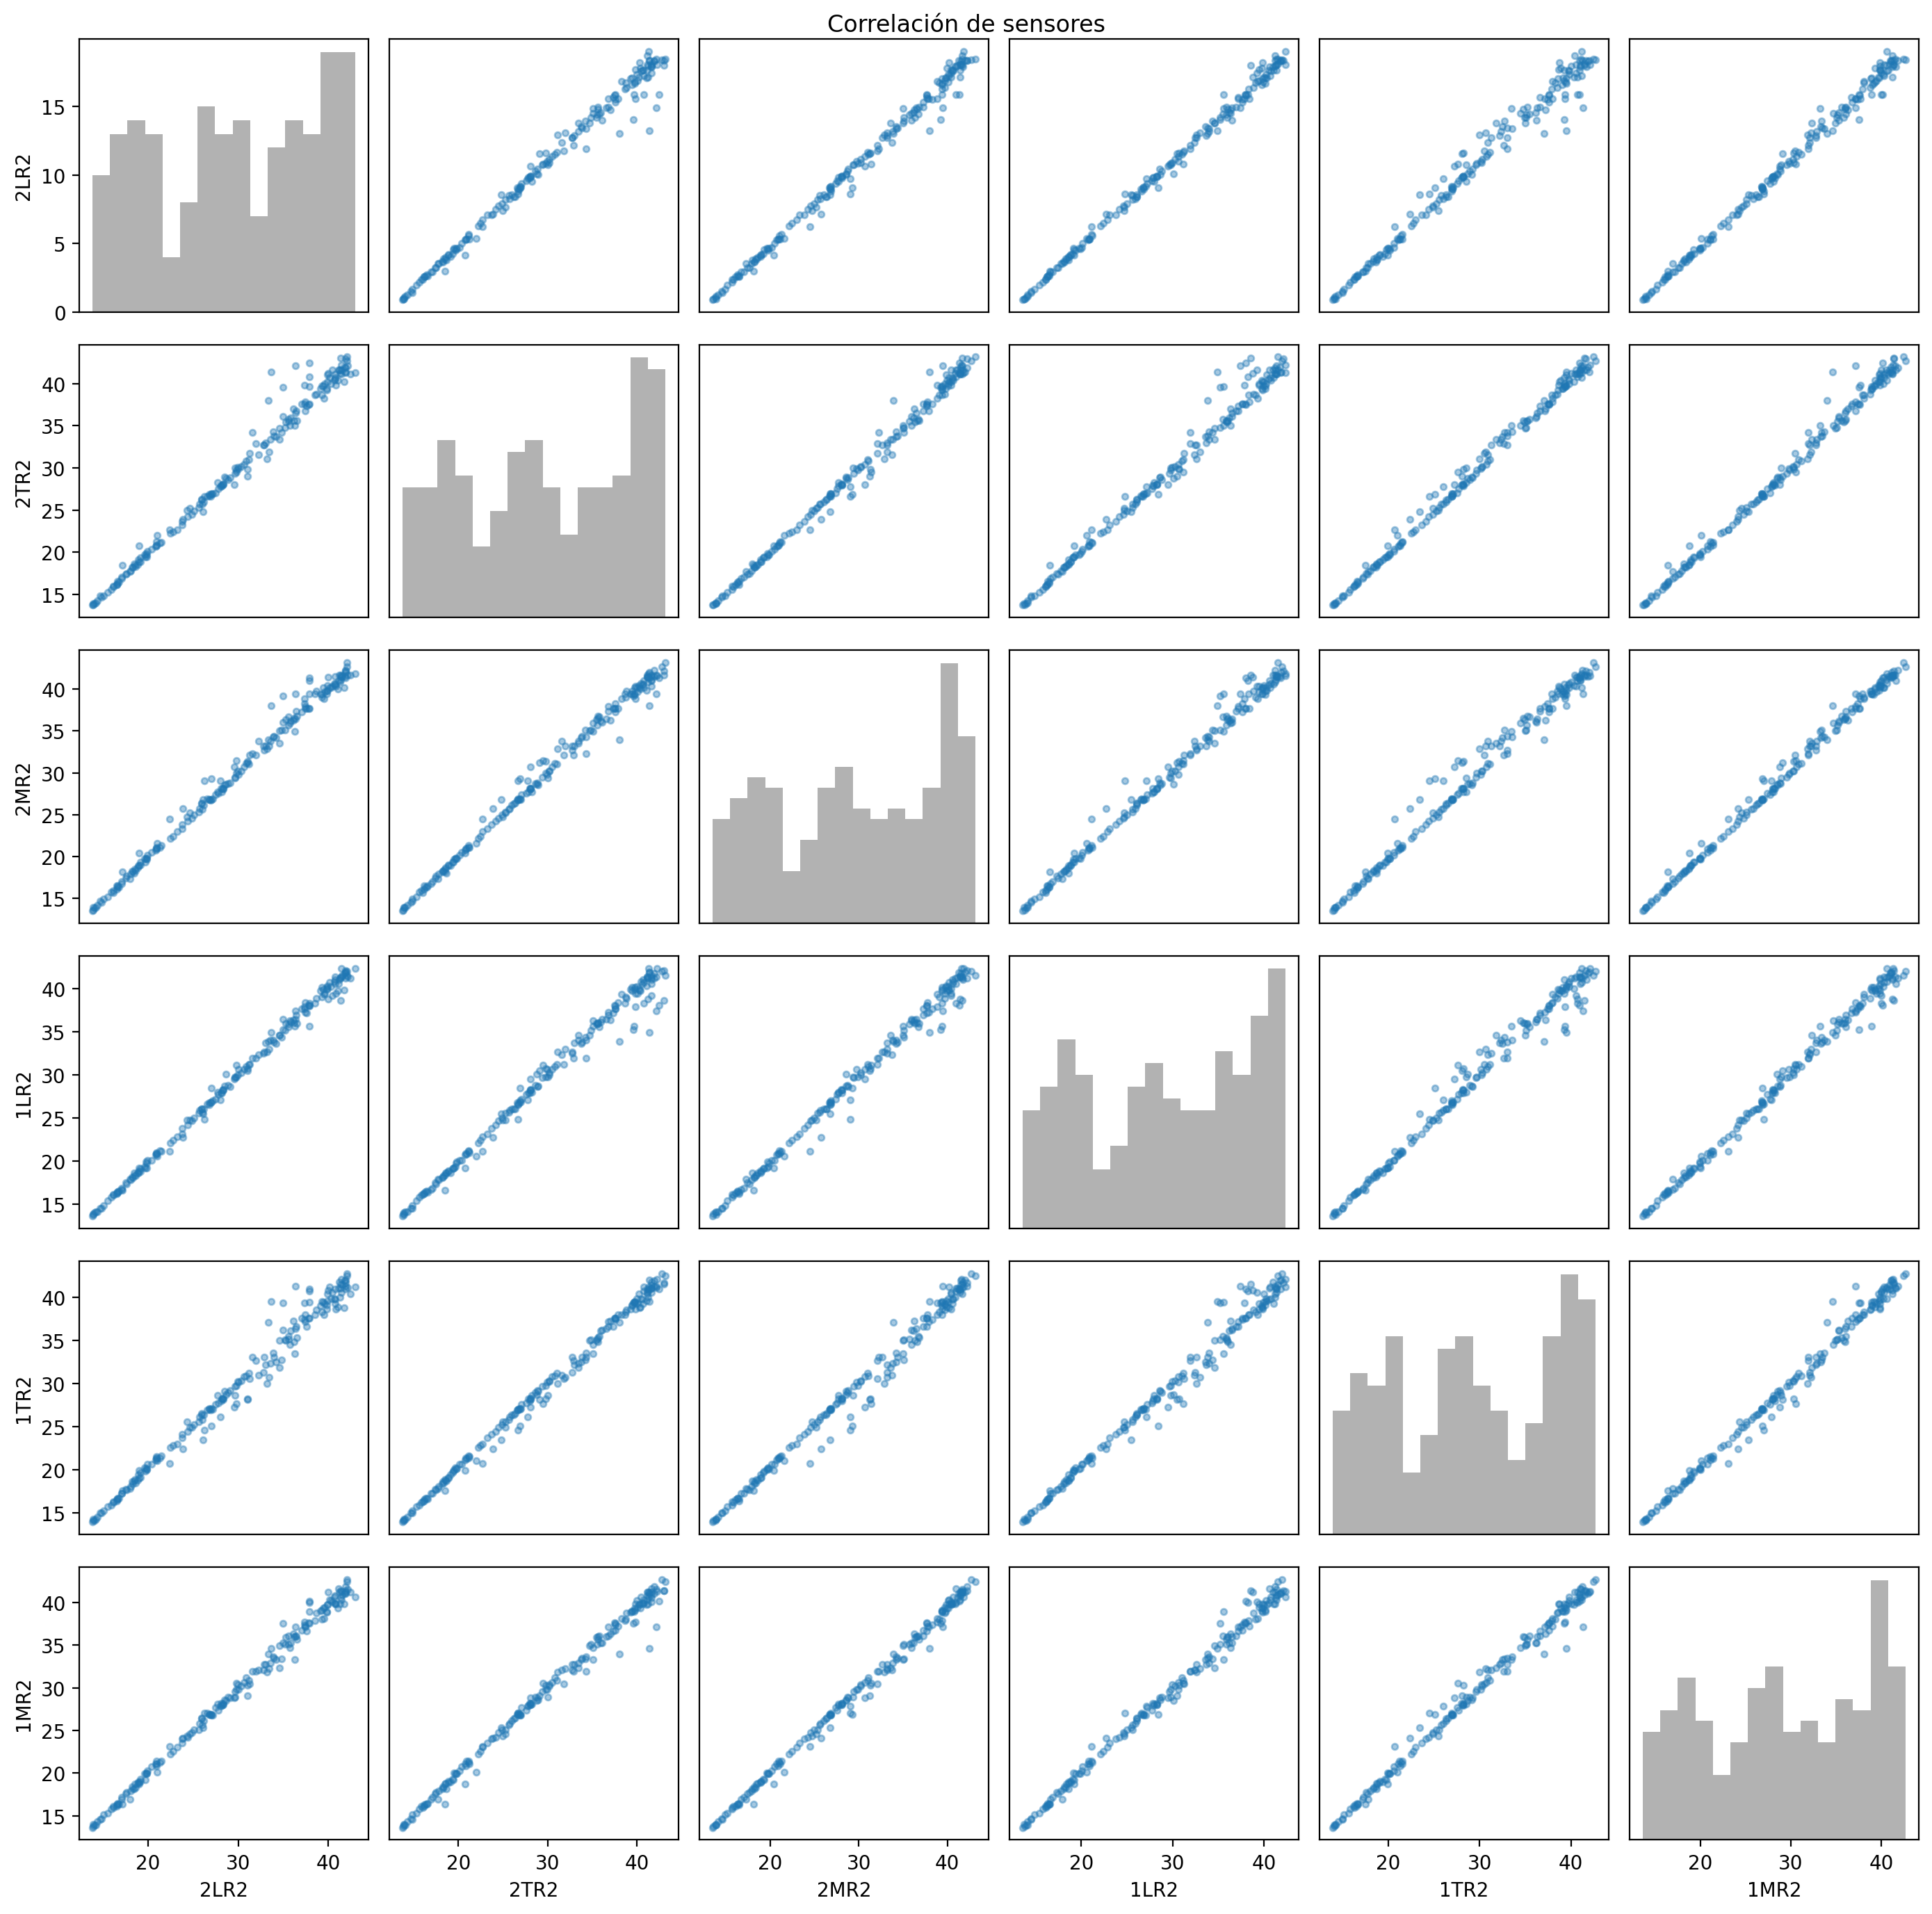

In [20]:
sensores = ["2LR2", "2TR2", "2MR2", "1LR2", "1TR2", "1MR2"]
n = len(sensores)

fig, axs = plt.subplots(n, n, figsize=(14, 14))
for i, xi in enumerate(sensores):
    for j, yj in enumerate(sensores):
        ax = axs[i, j]
        if i == j:
            # Histograma en la diagonal
            ax.hist(df[xi], bins=15, color="grey", alpha=0.6)
            ax.set_ylabel("")
            ax.set_xlabel("")
        else:
            # Scatterplot para cada combinación
            ax.scatter(df[yj], df[xi], alpha=0.4, s=10)
        if i == n-1:
            ax.set_xlabel(yj)
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_ylabel(xi)
        else:
            ax.set_yticks([])
plt.suptitle("Correlación de sensores")
plt.tight_layout()
plt.savefig("correlación-de-sensores.svg", bbox_inches="tight")
plt.show();

Es un poco chorra, pero es como la correlación de estadísticos por sensor de más arriba, nos vale para ver si algún sensor está raro (mirando la diagonal y viendo que sensores cercanos tienen un histograma radicalmente diferente) o si hay algún error (si algo fuera de la diagonal tiene pendiente rara o está la nube de puntos dispersa, _habemus problema_).

### Variabilidad diaria

Comparamos la desviación típica entre OTC y sin OTC.

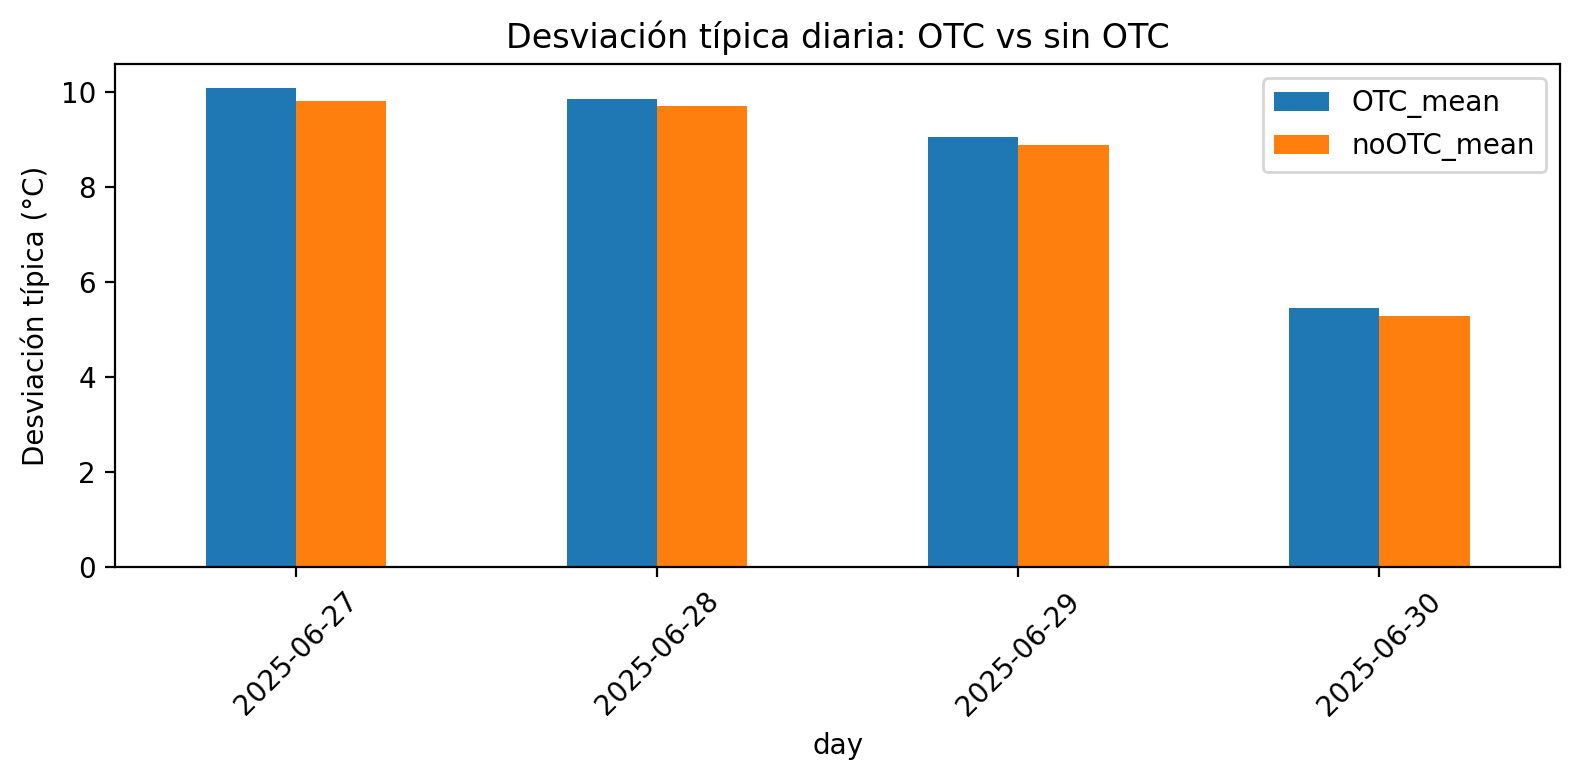

In [21]:
stds = df.groupby("day")[["OTC_mean", "noOTC_mean"]].std()
stds.plot(kind="bar", figsize=(8,4))
plt.title("Desviación típica diaria: OTC vs sin OTC")
plt.ylabel("Desviación típica (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("variabilidad-diaria.svg", bbox_inches="tight")
plt.show();

### Análisis por días y por grupos de días

Vamos a resumir las diferencias de temperatura por día natural y por grupos de días (e.g. quincenas)

#### Media diaria por situación del día

Agrupamos primero por día y por situación del día

In [22]:
stats_by_event = df.groupby(["day", "Solar event"])["diff_OTC_noOTC"].mean().unstack()
stats_by_event.head()

Solar event,dawn,dusk,noon,sunrise,sunset
day,,,,,
2025-06-27,-0.073810,-0.067778,0.546889,0.772917,0.505833
2025-06-28,-0.048333,-0.110000,0.282000,0.743333,0.375833
2025-06-29,-0.087619,-0.068889,0.318222,0.589167,0.223333
2025-06-30,-0.050952,NaN,0.288222,0.732500,-0.094286


Veamos los estadísticos de las diferencias:

In [23]:
stats_by_event.describe().T

,count,mean,std,min,25%,50%,75%,max
Solar event,,,,,,,,
dawn,4.0,-0.065179,0.018834,-0.087619,-0.077262,-0.062381,-0.050298,-0.048333
dusk,3.0,-0.082222,0.024063,-0.110000,-0.089444,-0.068889,-0.068333,-0.067778
noon,4.0,0.358833,0.126364,0.282000,0.286667,0.303222,0.375389,0.546889
sunrise,4.0,0.709479,0.082007,0.589167,0.696667,0.737917,0.750729,0.772917
sunset,4.0,0.252679,0.258521,-0.094286,0.143929,0.299583,0.408333,0.505833


Podemos ver, una vez más, que de día (noon, sunrise, sunset) OTC calientan, sobre todo tras el amanecer, hasta mediodía, y que de noche (dawn, dusk) el efecto puede ser neutro o de ligero enfriamiento.

#### Análisis por grupos de días

En realidad hacemos el cálculo por intervalos de $N$ días, así lo generalizamos. Cuandop tenga suficientes días, pues lo hago con quincenas.

In [24]:
N = 2

Ahora agrupamos los datos en bloques de $N$ intervalos y calculamos la media de la diferencia OTC vs. no OTC en cada bloque, para ver si pillamos alguna tendencia.

In [25]:
start = df.index.min().normalize()

# Número de días que han pasado desde "start" // N + 1
days_since = (df.index - start) // pd.Timedelta(days=1)
df[f"{N}-days group"] = (days_since // N + 1).astype("int64")
set(df[f"{N}-days group"])

# Estadísticos por bloque
block_stats = df.groupby(f"{N}-days group")["diff_OTC_noOTC"]
block_stats.describe()

,count,mean,std,min,25%,50%,75%,max
2-days group,,,,,,,,
1,96.0,0.305972,0.497094,-0.423333,-0.083333,0.110000,0.625833,1.533333
2,92.0,0.202717,0.400132,-0.310000,-0.068333,0.048333,0.351667,1.853333


Podemos ver también las diferencias de estos grupos por periodo del día. 

In [26]:
block_stats = df.groupby([f"{N}-days group", "Solar event"])["diff_OTC_noOTC"]
block_stats.describe()

count      mean       std       min       25%  \
2-days group Solar event                                                  
1            dawn          28.0 -0.061071  0.070197 -0.153333 -0.119167   
             dusk           6.0 -0.088889  0.081994 -0.203333 -0.135833   
             noon          30.0  0.414444  0.446924 -0.360000  0.142500   
             sunrise       16.0  0.758125  0.511069 -0.100000  0.425000   
             sunset        16.0  0.440833  0.575902 -0.423333  0.071667   
2            dawn          28.0 -0.069286  0.081792 -0.236667 -0.114167   
             dusk           3.0 -0.068889  0.101452 -0.143333 -0.126667   
             noon          30.0  0.303222  0.292594 -0.310000  0.076667   
             sunrise       16.0  0.660833  0.550720 -0.006667  0.178333   
             sunset        15.0  0.075111  0.285126 -0.176667 -0.108333   

                               50%       75%       max  
2-days group Solar event                                
1            dawn        -0.065000 -0.018333  0.130000  
             dusk        -0.091667 -0.037500  0.023333  
             noon         0.410000  0.630833  1.230000  
             sunrise      0.898333  1.115833  1.526667  
             sunset       0.288333  0.860000  1.533333  
2            dawn        -0.060000 -0.002500  0.050000  
             dusk        -0.110000 -0.031667  0.046667  
             noon         0.256667  0.594167  0.820000  
             sunrise      0.606667  0.971667  1.853333  
             sunset      -0.040000  0.158333  0.693333

## Preguntas

Ya que hablaremos de día y de noche, vamos a agrupar en esta dos clases las situaciones calculadas del día en función de la hora.

In [27]:
solar_day = ["noon", "sunrise", "sunset"]
solar_night = ["dawn", "dusk"]

df["period"] = df["Solar event"].apply(lambda x: "day" if x in solar_day else "night")

df[['Solar event', 'period']].head(25)

,Solar event,period
Date,,
2025-06-27 00:00:00+02:00,dawn,night
2025-06-27 00:30:00+02:00,dawn,night
2025-06-27 01:00:00+02:00,dawn,night
2025-06-27 01:30:00+02:00,dawn,night
2025-06-27 02:00:00+02:00,dawn,night
2025-06-27 02:30:00+02:00,dawn,night
2025-06-27 03:00:00+02:00,dawn,night
2025-06-27 03:30:00+02:00,dawn,night
2025-06-27 04:00:00+02:00,dawn,night


Con esta dicotomía simplificamos los contrastes de hipótesis que vienen más adelante.

### 1. ¿Las OTCs calientan significativamente por el día? ¿Cuánto?

#### Hipótesis

- **$H_0$ (nula)**: La media de la diferencia (OTC - sin OTC) durante el día es igual a 0 (no hay calentamiento).
- **$H_1$ (alternativa)**: La media de la diferencia es mayor que 0 (OTC calienta). _(ahora que lo pienso no sé si lo he hecho bien, porque igual tendría que haber dicho que es diferente a 0?)_

**Test elegido**: $t$ de una muestra, unilateral derecha.

- Variable: diferencias de temperatura durante el día (`diff_OTC_noOTC` en periodo "día").
- Comprobamos si la media es mayor que 0.
- Nivel de significancia: $\alpha$ = 0,05.

In [28]:
day_diff = df[df["period"] == "day"]["diff_OTC_noOTC"]

t_day, p_day_two_tailed = ttest_1samp(day_diff, 0)
p_day = (p_day_two_tailed / 2) if t_day > 0 else 1 - (p_day_two_tailed / 2)

print(f"t       = {t_day}")
print(f"p-value = {p_day}")
print(f"Mean    = {day_diff.mean()}")
print(f"Size    = {len(day_diff)}")

t       = 9.898584440189724
p-value = 1.289850084031223e-17
Mean    = 0.4261246612466129
Size    = 123


El **p-valor es mucho menor que 0.05**, así que rechazamos $H_0$; existe evidencia significativa muy fuerte de que la OTC caliente durante el día, con una media de $\sim 0.43^{\circ}C$

**Ojo**: Me ha dicho rafa que existe autocorrelación temporal; el $t$-test asume independiencia, así que habría que añadir _bootstrap_ como sensibilidad. Con bootstrap se evitan las suposiciones de normalidad e independiencia.

In [29]:
rng = np.random.default_rng(42)

def ci_bootstrap(x, iters=10000, q=(2.5, 97.5)):
    x = np.asarray(x.dropna())
    boots = rng.choice(x, (iters, x.size), replace=True).mean(axis=1)
    return np.percentile(boots, q)

day_ci   = ci_bootstrap(df.loc[df['period']=='day','diff_OTC_noOTC'])
night_ci = ci_bootstrap(df.loc[df['period']=='night','diff_OTC_noOTC'])
print("CI95% día :", day_ci)
print("CI95% noche:", night_ci)

CI95% día : [0.34132453 0.5117107 ]
CI95% noche: [-0.08605128 -0.0494859 ]


Como 0 cae fuera de los intervalos de confianza del 95%, existe evidencia consistente de que la diferencia es mayor que $!= 0$.

### 2. ¿Las OTCs calientan o enfrían significativamente por la noche? ¿Cuánto?

#### Hipótesis

- **$H_0$ (nula)**: La media de la diferencia (OTC - sin OTC) durante la noche es mayor o igual a cero
- **$H_1$ (alternativa)**: La media de la diferencia OTC - sin OTC durante la noche es menor que cero.

**Test elegido**: $t$ de una muestra, unilateral izquierda

- Variable: diferencias de temperatura durante el día (`diff_OTC_noOTC` en periodo "noche").
- Comprobamos si la media es menor que 0.
- Nivel de significancia: $\alpha$ = 0,05.

In [30]:
night_diff = df[df["period"] == "night"]["diff_OTC_noOTC"]

t_night, p_night_two_tailed = ttest_1samp(night_diff, 0)
p_night = (p_night_two_tailed / 2) if t_night < 0 else 1 - (p_night_two_tailed / 2)

print(f"t       = {t_night}")
print(f"p-value = {p_night}")
print(f"Mean    = {night_diff.mean()}")
print(f"Size    = {len(night_diff)}")

t       = -7.143328295530377
p-value = 5.210359372113493e-10
Mean    = -0.06753846153846144
Size    = 65


El **p-valor es mucho menor que 0.05**, así que de nuevo rechazamos $H_0$; existe evidencia significativa de que la OTC enfría durante la noche con una media de $\sim -0.07^{\circ}C$

---

Sobre lo que me comentas en el correo:

### 1. Detectar y eliminar anomalías

Lo primero y principal, prefiero no eliminar y sí marcar y excluir de cálculos. Dicho esto, se me ocurren:

- Plantear unos rangos mínimos (-20º), máximos (50º) y por step (-10º > dT/dt > 10º) y si se rebasan, pues se marcan.
- Con los OTC que están cerquita, podemos calcular |T_sensor − mediana(sensores cerquita del mismo tipo (OTC o no-OTC))|. Si superan la k*MAD (k = 3), pues se marca también.
- DBSCAN, Isolation Forest sobre features por timestamp: T, dT/dt, \Delta(OTC-noOTC), evento solar. Los que no se clasifiquen, marcados.
- Modelos que predigan la T_sensor dada la hora y el resto de sensores. Si el error es alto -> marcar.

### 2. Integrar datos telemáticos con excel manual

Sí, no habría problema. Lo que sí sería necesario es saber la correspondencia entre columnas (aunque si las columnas se llaman igual, mejor que mejor). Igual estaría interesante tener una base de datos dedicada para esto, porque lo ideal es que los datos estén concentrados en un sitio, y una base de datos relacional creo que sería genial para trabajar y para consultas.

### 3. Ideas de artículo

Hablas de viñedo maduro. Esto se me ha olvidado, estamos trabajando con viñados maduros? tenía en la cabeza que eran únicamente viñedos jóvenes.

Para lo que dices, genial, no sé si eso es suficientemente relevante o no para este dominio. Yo imagino que sí, mostrando cuánto aumentan las máximas diurnas y cuánto disminuyen las mínimas nocturnas y sacando las curvas de calentamiento medio horario o de diferencias de temperatura puede estar guay, porque tiene pinta de que puede dar indicios de si las OTC son o no fiables, o cuándo lo son para alterar el microclima del viñedo.

No sé si este verano hemos tenido eventos de este tipo, pero ya que tenemos muchos datos (y vamos a tener más), podríamos estudiar si las OTC amplifican o amortiguan los eventos extremos como heladas u olas de calor.

Se me ocurre también que el uso de "reloj solar" en lugar de la hora normal. Si te fijas, divido en 5 eventos por la posición del sol en el cielo en ese momoento dado. Esto es puede usar para corregir desajustes entre sensores que registran horarios distintos o relojes mal calibrados y ayuda a detectar anomalías ligadas a que les dé de lleno el sol, por ejemplo. O cuando se vuela la OTC. ¿Poidría ser interesante?

Más, super-resolución de sensores. Si tenemos sensores que van a distintas frecuencias, podemos entrenar un modelos para que interpolen de forma inteligente los huecos de los sensores de menor frecuencia (o los sensores que en algunas medidas han cogido errores).

Más, crear una PINN que aprenda a predecir la temperatura en OTC y no OTC usando las leyes físicas del intercambio térmico, usando como entradas hora, evento solar, OTC/noOTC, temperatura previa, humedad si tenemos, ...

Más, lo subimos un poco más, y desarrollamos un gemelo digital de la parcela sensorizada. Combinamos los datos de sensores, el modelo PINN de justo antes, realizamos una simulación física del intercamio de energía bajos las OTC y hacemos un cuadro de mando interactivo.

---